In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess

In [2]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated" or dataset_type == 'both'):
        break
    print("Invalid argument")

Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: automated


In [3]:
# first call bash script to get necessary file inputs
# choose man_query_data.csv as input file during file 1b construction, then names_ids.csv for R prompts
# subprocess.call(['./exec.sh'])

In [4]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['permalink', 'namespace_manual', 'worms_higher_order_manual']
elif (dataset_type == 'automated'):
    columns = ['permalink', 'namespace_automated']
else:
    columns = ['permalink', 'namespace_manual', 'namespace_automated', 'worms_higher_order_manual']

In [5]:
# initialize data frame from input
samples = pd.read_csv("level_1b.csv", usecols=columns)

In [6]:
# get higher order data if dataset is automated
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr'])
    # merge to get taxa data
    samples = pd.merge(samples, auto_taxon_info, how='left', left_on='namespace_automated', right_on='name')
    # rename resolved_higher_order column to match
    samples.rename(columns={'resolved_higher_order_fromgnr':'worms_higher_order_automated'}, inplace=True)
elif (dataset_type == 'manual'):
    man_taxon_info = pd.read_csv('resolved_manual.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    samples = pd.merge(samples, man_taxon_info, how='left', left_on='namespace_manual', right_on='name')
else:
    auto_taxon_info = pd.read_csv('resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr'])
    # merge to get taxa data
    samples = pd.merge(samples, auto_taxon_info, how='left', left_on='namespace_automated', right_on='name')
    # rename resolved_higher_order column to match
    samples.rename(columns={'resolved_higher_order_fromgnr':'worms_higher_order_automated'}, inplace=True)
    man_taxon_info = pd.read_csv('resolved_manual.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    samples = pd.merge(samples, man_taxon_info, how='left', left_on='namespace_manual', right_on='name')

In [7]:
# separate out roi id from permalink
samples['roi'] = samples['permalink']
samples.roi = samples.roi.str.slice(68, 74)
# gets rid of leading zeros
samples.roi = samples.roi.str.lstrip("0")
# cut permalink to just be permalink of sample
samples.permalink = samples.permalink.str.slice(0, 67)

In [8]:
# read in geolocation data
geo_data = pd.read_csv("comparison.csv", usecols=['gps_furuno_latitude', 'pid'])
samples = pd.merge(samples, geo_data, how='left', left_on='permalink', right_on='pid')

In [9]:
# for now just use volume from original file- temporary fix
volume_data = pd.read_csv('IFCB_count_manual_transect_winter_2018_20190530.csv', 
                          usecols=['sample_identifier', 'volume_imaged'])
volume_data['sample_identifier'] = 'http://ifcb-data.whoi.edu/NESLTER_transect/'+volume_data['sample_identifier'].astype(str)
samples = pd.merge(samples, volume_data, how='inner', left_on='permalink', right_on='sample_identifier')

In [10]:
# calculate abundance based on higher order and latitude
if (dataset_type == 'both'):
    # need 2 data frames for both
    auto_samples = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_automated']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first'
    }
).reset_index()
    # manual data frame
    manual_samples = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_manual']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first'
    }
).reset_index()
else:
    samples = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_{}'.format(dataset_type)]).agg(
        {
            'roi': 'count',
            'volume_imaged': 'first'
        }
    ).reset_index()

In [11]:
# calculate concentration from abundance and volume
if (dataset_type == 'both'):
    # calculate concentration for automated classifications
    auto_samples['concentration'] = auto_samples.roi/auto_samples.volume_imaged
    # convert to float
    auto_samples.concentration = auto_samples.concentration.astype(float)
    # calculate concentrations for manual classifications
    manual_samples['concentration'] = manual_samples.roi/manual_samples.volume_imaged
    # convert to float
    manual_samples.concentration = manual_samples.concentration.astype(float)
else:
    samples['concentration'] = samples.roi/samples.volume_imaged
    # convert to float
    samples.concentration = samples.concentration.astype(float)

In [12]:
# filter out to only read Diatoms
if (dataset_type == 'both'):
    auto_samples = auto_samples[auto_samples['worms_higher_order_automated'] == 'Bacillariophyceae'].reset_index()
    manual_samples = manual_samples[manual_samples['worms_higher_order_manual'] == 'Bacillariophyceae'].reset_index()

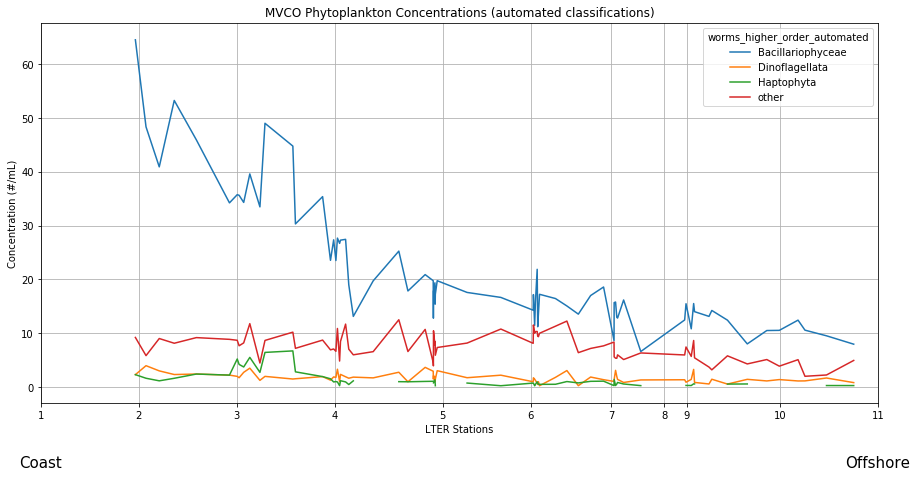

In [13]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
if (dataset_type == 'both'):
    grouped = auto_samples.groupby(['gps_furuno_latitude', 'worms_higher_order_automated']).sum()['concentration']
    grouped.unstack().plot(ax=ax)
    grouped = manual_samples.groupby(['gps_furuno_latitude', 'worms_higher_order_manual'.format(dataset_type)]).sum()['concentration']
    grouped.unstack().plot(ax=ax)
else:
    grouped = samples.groupby(['gps_furuno_latitude', 'worms_higher_order_{}'.format(dataset_type)]).sum()['concentration']
    grouped.unstack().plot(ax=ax)
# add titles and axes labels
plt.xlabel('LTER Stations')
plt.ylabel('Concentration (#/mL)')
plt.title('MVCO Phytoplankton Concentrations ({} classifications)'.format(dataset_type))
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
ax.set_xticklabels(np.arange(1,12))
# set comments
ax.text(41.1967, -15, "Coast", size = 15, ha = 'center')
ax.text(39.7733, -15, "Offshore", size = 15, ha = 'center')
# invert x axis
ax.invert_xaxis()
plt.show()
